In [1]:
%matplotlib inline
import numpy as np
#import matplotlib.pyplot as plt
#import multiprocessing


import torch
#torch.multiprocessing.set_start_method("forkserver")

import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import torchvision.transforms as transforms
from torch.utils.data import  Dataset, TensorDataset, DataLoader


#sys.path.append('/mnt/home/e209440/')
#sys.path.append('/home/r120084/pytorch_lib/pytorch')
import lib.pytorch_trainer as ptt

from src.imgnet_utils import my_transforms,denormalize

from src.data_loader import _create_dataLoader

from src.Dataset import KaggleSafeDriverDataset

from src.plot_utils import (plot_classes, plot_distribution,
                            statistical_analysis_image, classDistribution,
                            plot_metrics,visualize_predictions,
                            plot_cm_train_valid,plot_layers_weight)
                           
from src.features_extractor import (MyResNet, MyInception, 
                                    ExtractFeatures, getPrediction,tensor2numpy)


In [2]:
!free -h
!nvidia-smi

              total        used        free      shared  buff/cache   available
Mem:           220G        3.4G        212G         25M        4.1G        215G
Swap:            0B          0B          0B
Sat Nov 18 13:21:28 2017       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 384.90                 Driver Version: 384.90                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00003609:00:00.0 Off |                    0 |
| N/A   42C    P0    72W / 149W |   2607MiB / 11439MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla K80           Off  | 00004BDC:0

In [3]:
print("{} GPU's available:".format(torch.cuda.device_count()) )
cpu_count = torch.multiprocessing.cpu_count()
print('\ncpu_count: ', cpu_count)

4 GPU's available:

cpu_count:  24


In [4]:
use_gpu= True
use_DataParalel= False
use_CPU= False

if use_CPU: 
    print("Using multiprocessing in {} CPU's".format(cpu_count))

if use_gpu: 
    
#    device_id = 2  # Chose the GPU to be used. 
#    torch.cuda.device(device_id)
    print('Using only one GPU') #{} '.format(device_id))

if use_DataParalel:
    print("Using DataParalel in all {} GPUS".format(torch.cuda.device_count()))
 


Using only one GPU



# Choose dataset 

In [5]:
#if use_gpu:
path2train = "/mnt/home/e209440/data/train" # with gpu 
path2test = "/mnt/home/e209440/data/test" 

#else:
#    path2train = "/home/r120084/project/data/train" #server without gpu
#    path2test = "/home/r120084/project/data/test"
        

# Images transformation

In [6]:
imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std  = np.array([0.229, 0.224, 0.225])


# Data augmentation and normalization for training 
data_transforms = {
    'train': transforms.Compose([
#        transforms.RandomHorizontalFlip(), First try withouth Data Augmentation 
        transforms.Lambda(my_transforms),
        transforms.ToTensor(),
        transforms.Normalize(imagenet_mean, imagenet_std),
    ]),
    'valid': transforms.Compose([
        transforms.Lambda(my_transforms),
        transforms.ToTensor(),
        transforms.Normalize(imagenet_mean, imagenet_std),
    ]),
}


# Creating  Dataset & Dataloader

In [7]:
batch_size = 120

use_only = 0.1 # Use only is the percentage of the full dataset

In [8]:
dsets = {
    'train': KaggleSafeDriverDataset(path2train, transforms=data_transforms['train'],use_only=use_only),
    'valid': KaggleSafeDriverDataset(path2train, transforms=data_transforms['valid'],use_only=use_only, is_val=True, val_size=0.2),
    'test':  KaggleSafeDriverDataset(path2test, transforms=data_transforms['valid'],use_only=use_only, is_test=True),
}

In [9]:
dset_loaders = _create_dataLoader(dsets, batch_size, 
                                  num_workers=cpu_count, use_DataParalel=use_DataParalel,
                                  use_gpu=use_gpu)


In [10]:
dset_sizes = {x: len(dsets[x]) for x in ['train','valid', 'test']} 
dset_classes = len(dsets['train'].y)
dset_classes, dset_sizes

# Datates has much more samples than datatrain ***It comes from the test.zip****

(1794, {'test': 7972, 'train': 1794, 'valid': 448})

# Plotting some examples

In [ ]:
plot_classes(dset_loaders['train'])

# Data Analysis

In [ ]:
statistical_analysis_image(dset_loaders['train'])

In [ ]:
classDistribution(dsets['train'])

# Checking GPU usage

In [ ]:
!free -h
!nvidia-smi
    

# Choosing Model

In [11]:
use_resnet = True

if use_resnet:
    model = MyResNet()
else:
    model = myInception()

if use_gpu:
    print('Using GPU')# {}'.format(device_id))
    model.cuda()
    
if use_DataParalel:
    print("Using all GPU's ")
    model = torch.nn.DataParallel(model,device_ids=[0,1,2])
#    model.cuda()


Using GPU


In [12]:
#print(model)

In [13]:
if use_DataParalel:
    convOutput_train = ExtractFeatures(dset_loaders['train'], model.module.mrnc,use_gpu=use_DataParalel)
    convOutput_valid = ExtractFeatures(dset_loaders['valid'], model.module.mrnc,use_gpu=use_DataParalel)

if  use_gpu:    
    convOutput_train = ExtractFeatures(dset_loaders['train'], model.mrnc,use_gpu=use_gpu)
    convOutput_valid = ExtractFeatures(dset_loaders['valid'], model.mrnc,use_gpu=use_gpu)

if not use_gpu and not use_DataParalel:
    convOutput_train = ExtractFeatures(dset_loaders['train'], model.mrnc)
    convOutput_valid = ExtractFeatures(dset_loaders['valid'], model.mrnc)



predict: 14/14 ok
predict: 3/3 ok


In [14]:
print(convOutput_train['true'].size(), convOutput_train['pred'].size())
print(convOutput_valid['true'].size(), convOutput_valid['pred'].size())

torch.Size([1794]) torch.Size([1794, 4096])
torch.Size([448]) torch.Size([448, 4096])


In [15]:
print(convOutput_train['true'].type(), convOutput_train['pred'].type())

torch.cuda.LongTensor torch.cuda.FloatTensor


In [16]:
conv_dset ={
    'train': TensorDataset(convOutput_train['pred'], convOutput_train['true']),
    'valid': TensorDataset(convOutput_valid['pred'], convOutput_valid['true'])
} 

In [17]:
dset_loaders_convnet = _create_dataLoader(conv_dset, batch_size, 
                                  num_workers=cpu_count, use_DataParalel=True,
                                  use_gpu=False,shuffle= False)

In [18]:
len(dset_loaders_convnet['train'])

15

In [19]:
#path2saveModel = '/home/r120084/project/models/distractdriver'
path2saveModel = '/mnt/home/e209440/models/ResNetDistractDriver' 

#if use_gpu:    
 #   path2saveModel = '/mnt/home/r120084/project/models/distractdriver' 
#    path2saveModel = '/mnt/home/e209440/models/ResNetDistractDriver' 
    
savebest = ptt.ModelCheckpoint(path2saveModel,reset=True, verbose=1)

In [20]:
loss_fn = nn.CrossEntropyLoss()
num_epochs = 50

if use_DataParalel:
    optimizer =  optim.Adam(model.mrnd.parameters(), lr=1e-3)
    
    params = {'model' : model.module.mrnd, 
        'criterion': loss_fn,  
        'optimizer': optimizer, 
        'callbacks': [savebest,  ptt.PrintCallback()] #ptt.PlotCallback(),
    }

if use_gpu:    
    
    optimizer =  optim.Adam(model.mrnd.parameters(), lr=1e-3)
    
    params = {'model' : model.mrnd, 
        'criterion': loss_fn,  
        'optimizer': optimizer, 
        'callbacks': [savebest,  ptt.PrintCallback()] #ptt.PlotCallback(),
    }


    
else:    
    optimizer =  optim.Adam(model.mrnd.parameters(), lr=1e-3)
    params = {'model' : model.mrnd, 
        'criterion': loss_fn,  
        'optimizer': optimizer, 
        'callbacks': [savebest,  ptt.PrintCallback()] #ptt.PlotCallback(),
    }
       
scheduler = StepLR(optimizer, step_size=5, gamma=0.75)


In [21]:
trainer = ptt.DeepNetTrainer(**params)

In [22]:
trainer.fit_loader(num_epochs, dset_loaders_convnet['train'], dset_loaders_convnet['valid'])

Start training for 50 epochs
  1:   0.3s   T: 3.03960   V: 2.53572 best
  2:   0.1s   T: 2.37197   V: 2.32301 best
  3:   0.1s   T: 2.28504   V: 2.32129 best
  4:   0.1s   T: 2.25224   V: 2.30375 best
  5:   0.1s   T: 2.21226   V: 2.27406 best
  6:   0.1s   T: 2.14562   V: 2.18355 best
  7:   0.1s   T: 2.02458   V: 2.05656 best
  8:   0.1s   T: 1.86490   V: 1.91726 best
  9:   0.1s   T: 1.66141   V: 1.82430 best
 10:   0.1s   T: 1.46673   V: 1.74446 best
 11:   0.1s   T: 1.28715   V: 1.45215 best
 12:   0.1s   T: 1.10874   V: 1.21330 best
 13:   0.1s   T: 0.96199   V: 1.01156 best
 14:   0.1s   T: 0.85277   V: 0.92740 best
 15:   0.1s   T: 0.75888   V: 0.93867 
 16:   0.1s   T: 0.70474   V: 0.80331 best
 17:   0.1s   T: 0.59550   V: 0.64610 best
 18:   0.1s   T: 0.56191   V: 0.80532 
 19:   0.1s   T: 0.53526   V: 0.73399 
 20:   0.1s   T: 0.38913   V: 0.66717 
 21:   0.1s   T: 0.34432   V: 0.87072 
 22:   0.1s   T: 0.36403   V: 0.55757 best
 23:   0.1s   T: 0.30725   V: 0.64330 
 24:  

In [23]:
model.mrnd = trainer.model

In [ ]:
if use_gpu:
    !free -h
    !nvidia-smi

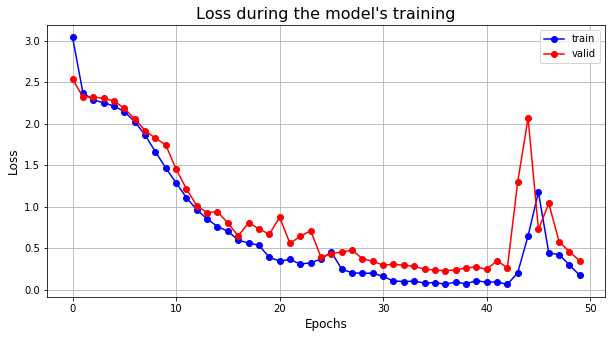

In [24]:
plot_metrics(trainer)

In [25]:
train_eval = trainer.evaluate_loader(dset_loaders_convnet['train'])
valid_eval = trainer.evaluate_loader(dset_loaders_convnet['valid'])

evaluate: 14/14 ok
evaluate: 3/3 ok


In [26]:
train_eval, valid_eval

({'losses': 0.07738754242957635}, {'losses': 0.34564619404929026})

In [27]:
dset_loaders_wshuffle = _create_dataLoader(dsets, batch_size, num_workers=cpu_count,
                                           use_gpu=use_gpu,use_DataParalel=use_DataParalel, shuffle=False)


In [28]:
result_train = ExtractFeatures(dset_loaders_wshuffle['train'], model,use_gpu=use_gpu)
result_valid = ExtractFeatures(dset_loaders_wshuffle['valid'], model,use_gpu=use_gpu)

predict: 14/14 ok
predict: 3/3 ok


In [29]:
result_train['pred'] = getPrediction(result_train['pred'])
result_valid['pred'] = getPrediction(result_valid['pred'])

In [30]:
result_train['pred'] = tensor2numpy(result_train['pred'])
result_train['true'] = tensor2numpy(result_train['true'])

result_valid['pred'] = tensor2numpy(result_valid['pred'])
result_valid['true'] = tensor2numpy(result_valid['true'])

In [31]:
correct_train = (result_train['true'] == result_train['pred']).sum()
correct_valid = (result_valid['true'] == result_valid['pred']).sum()

In [32]:
print('Train: ', correct_train, '/', len(conv_dset['train']) )
print('Valid: ', correct_valid, '/', len(conv_dset['valid']) )

Train:  1757 / 1794
Valid:  402 / 448


In [33]:
lst_correct = np.where(result_train['true'] == result_train['pred'])[0]
lst_incorrect = np.where(result_train['true'] != result_train['pred'])[0]

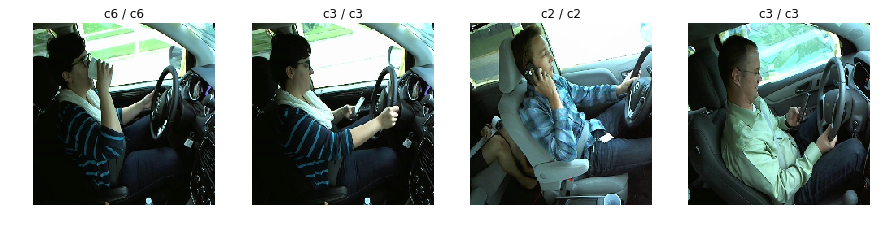

In [34]:
visualize_predictions(dsets['train'],lst_correct,result_train)

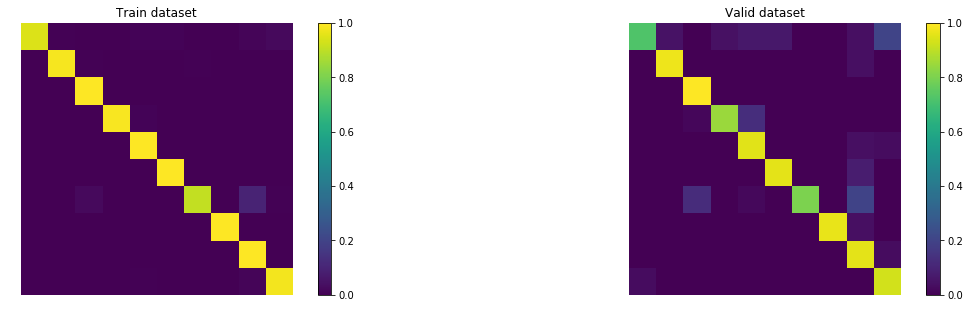

In [35]:
plot_cm_train_valid(result_train,result_valid)

In [ ]:
'''def plot_layers_weight(img_width, img_height, conv_model = model.mrnc, ncols = 8, H = 14, W=30):


    rand_idx = random.randrange(0, len(dsets['train']))
    input, _ = dsets['train'][rand_idx]
    input = input.view(1, 3, img_width, img_height)

    if use_gpu:
        x = Variable(input.cuda())
    else:
        x = Variable(input)


    for name, layer in conv_model.named_children():
        x = layer(x)
        grid = torchvision.utils.make_grid(torch.transpose(x.data, 0, 1), normalize=True, 
                                           pad_value=1.0, padding=1).cpu().numpy()

        if name == 'max_pool':
            H /= 3/2
            W /= 3/2
        fig = plt.figure(figsize=(H,W))
        plt.imshow(grid.transpose((1,2,0)))
        plt.title(name)
        plt.axis('off')
        plt.show()
'''        

In [41]:
plot_layers_weight(dsets,img_width=224, img_height=224,conv_model = model.mrnc,use_gpu=use_gpu)

NameError: name 'Variable' is not defined